# Books Dataset Recommender System
Building a collaborative filtering recommender systems on books dataset

[Dataset on kaggle](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset)

## Contents
* Data cleaning
* Data understanding and EDA
* Data preprocessing
* Modeling 

In [143]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
sns.set(font_scale=1.3)

Three dataframes, one for books, one ratings and one for users

In [2]:
books = pd.read_csv('Books.csv')
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

C:\Users\ACER\AppData\Local\Temp\ipykernel_4676\1508424101.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv')


## Books Dataset

In [4]:
books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


In [5]:
books.shape

(271360, 8)

### Data Cleaning

In [9]:
books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Image-URL-M']]

In [11]:
books.rename({'Book-Title': 'title', 
              'Book-Author': 'author',
              'Year-Of-Publication': 'year', 
              'Image-URL-M': 'url'}, axis=1, inplace=True)

In [12]:
books.head(2)

,ISBN,title,author,year,url
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,http://images.amazon.com/images/P/0002005018.0...


In [13]:
books.isna().sum()

ISBN      0
title     0
author    1
year      0
url       0
dtype: int64

In [15]:
books.drop_duplicates(inplace=True)

In [16]:
books.duplicated().sum()

0

In [17]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ISBN    271360 non-null  object
 1   title   271360 non-null  object
 2   author  271359 non-null  object
 3   year    271360 non-null  object
 4   url     271360 non-null  object
dtypes: object(5)
memory usage: 12.4+ MB


Converting year to int 

The following rows are valued wrongly. We must swap the values between author and year

In [22]:
books[books['year'] == 'DK Publishing Inc']

,ISBN,title,author,year,url
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [32]:
%%capture
temp = books[books['year'] == 'DK Publishing Inc']
temp['year'] = 2000
temp['author'] = 'DK Publishing Inc'
books[books['year'] == 'DK Publishing Inc'] = temp
del temp

In [35]:
books[books['year'] == 'Gallimard']

,ISBN,title,author,year,url
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


In [36]:
%%capture
temp = books[books['year'] == 'Gallimard']
temp['year'] = 2003
temp['author'] = 'Gallimard'
books[books['year'] == 'Gallimard'] = temp
del temp

Now we can convert year 

In [39]:
books['year'] = books['year'].apply(int)

In [40]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ISBN    271360 non-null  object
 1   title   271360 non-null  object
 2   author  271359 non-null  object
 3   year    271360 non-null  int64 
 4   url     271360 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.4+ MB


### EDA

In [42]:
books.shape

(271360, 5)

In [41]:
books.nunique()

ISBN      271360
title     242135
author    102023
year         116
url       271044
dtype: int64

In [45]:
books.describe().T

,count,mean,std,min,25%,50%,75%,max
year,271360.0,1959.761273,257.992836,0.0,1989.0,1995.0,2000.0,2050.0


There are some wrong values like 0 year

### Total books in year

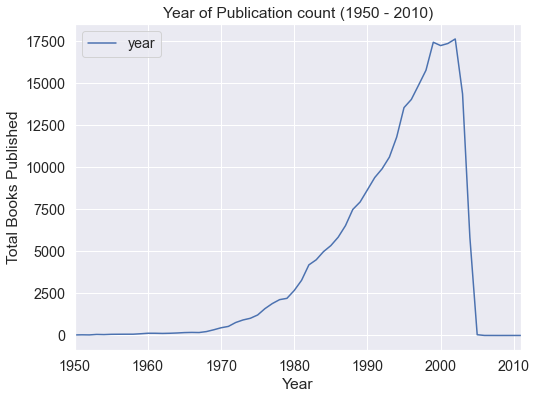

In [49]:
year_count = books['year'].value_counts()
year_count = pd.DataFrame(year_count)
plt.figure(figsize=(8, 6))
sns.lineplot(data=year_count)
plt.title('Year of Publication count (1950 - 2010)')
plt.xlim(1950, 2011)
plt.xlabel('Year')
plt.ylabel('Total Books Published')
plt.show()

## Users Dataset

In [52]:
users.head(3)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


In [53]:
users.shape

(278858, 3)

### Data Cleaning

In [54]:
users.rename({'User-ID': 'id', 
              'Location': 'location', 
              'Age': 'age'}, axis=1, inplace=True)

Extracting country

In [55]:
countries = []
cond = users['location'].str.split(',')
for cont in cond:
    countries.append(cont[-1])
users['country'] = countries

In [56]:
users.head(3)

,id,location,age,country
0,1,"nyc, new york, usa",NaN,usa
1,2,"stockton, california, usa",18.0,usa
2,3,"moscow, yukon territory, russia",NaN,russia


In [57]:
users.isna().sum()

id               0
location         0
age         110762
country          0
dtype: int64

In [58]:
users.duplicated().sum()

0

In [59]:
users = users[['id', 'country']]

In [60]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       278858 non-null  int64 
 1   country  278858 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


### EDA

In [66]:
users.head(3)

,id,country
0,1,usa
1,2,usa
2,3,russia


In [61]:
users.nunique()

id         278858
country       709
dtype: int64

In [65]:
users['country'].value_counts()[0:5]

 usa               139711
 canada             21658
 united kingdom     18538
 germany            17043
 spain              13147
Name: country, dtype: int64

### Top 5 countries

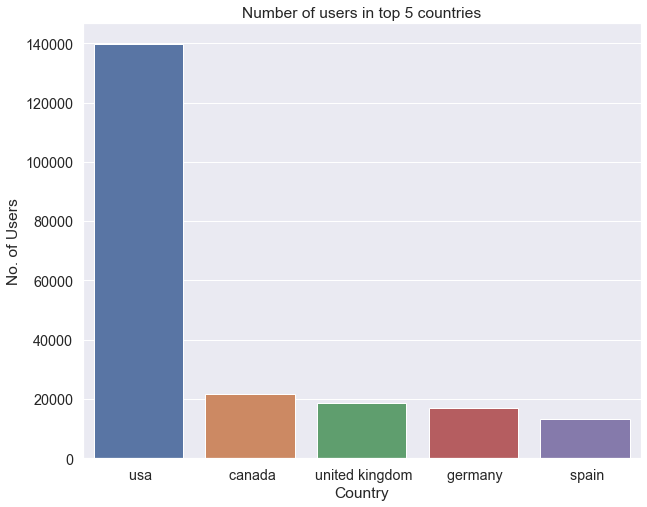

In [69]:
name = users['country'].value_counts().index.tolist()[0:5]
count = users['country'].value_counts().tolist()[0:5]
fig = plt.figure(figsize = (10, 8))
sns.barplot(x=name, y=count)
plt.xlabel('Country')
plt.ylabel('No. of Users')
plt.title('Number of users in top 5 countries')
plt.show()

## Ratings Dataset

In [70]:
ratings.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [71]:
ratings.rename({'User-ID': 'id', 
                'Book-Rating': 'rating'}, axis=1, inplace=True)

In [72]:
ratings.shape

(1149780, 3)

In [73]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   id      1149780 non-null  int64 
 1   ISBN    1149780 non-null  object
 2   rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [74]:
ratings.isna().sum()

id        0
ISBN      0
rating    0
dtype: int64

In [75]:
ratings.duplicated().sum()

0

## EDA

In [77]:
ratings.nunique()

id        105283
ISBN      340556
rating        11
dtype: int64

### Users ratings analysis

In [79]:
ratings['id'].value_counts()[0:5]

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
Name: id, dtype: int64

First user rated 13602 movies

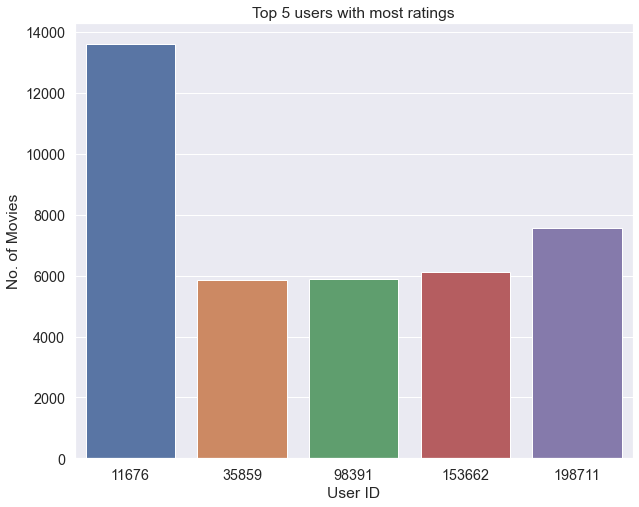

In [80]:
name = ratings['id'].value_counts().index.tolist()[0:5]
count = ratings['id'].value_counts().tolist()[0:5]
fig = plt.figure(figsize = (10, 8))
sns.barplot(x=name, y=count)
plt.xlabel('User ID')
plt.ylabel('No. of Movies')
plt.title('Top 5 users with most ratings')
plt.show()

### Ratings analysis

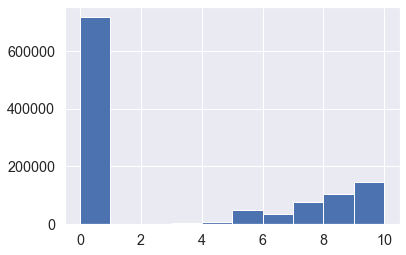

In [82]:
ratings['rating'].hist()
plt.show()

In [84]:
(len(ratings[ratings['rating'] == 0]) / len(ratings)) * 100

62.28226269373272

62.28% of ratings are zero and it means no rating. We remove them in next part

In [85]:
ratings['rating'].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: rating, dtype: int64

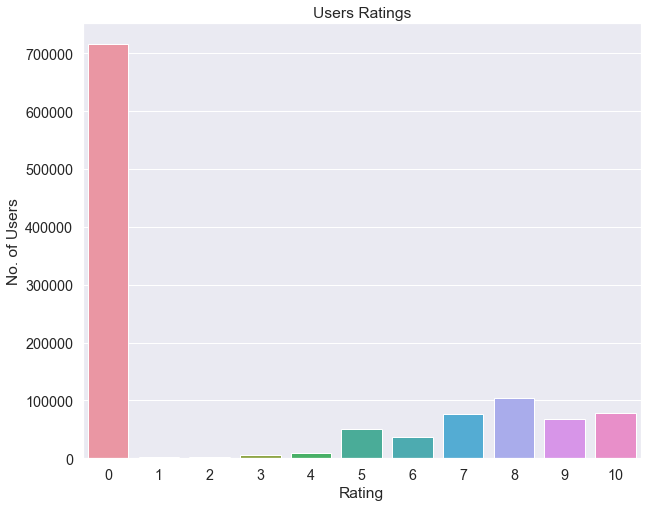

In [86]:
name = ratings['rating'].value_counts().index.tolist()
count = ratings['rating'].value_counts().tolist()
fig = plt.figure(figsize = (10, 8))
sns.barplot(x=name, y=count)
plt.xlabel('Rating')
plt.ylabel('No. of Users')
plt.title('Users Ratings')
plt.show()

---
## Preprocessing

At first we merge books and ratings

In [87]:
books_with_ratings = pd.merge(books, ratings, on='ISBN')

In [89]:
books_with_ratings.head(3)

,ISBN,title,author,year,url,id,rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,http://images.amazon.com/images/P/0002005018.0...,11400,0


In [90]:
books_with_ratings.shape

(1031136, 7)

In [91]:
books_with_ratings.dropna(inplace=True)

In [92]:
books_with_ratings.shape

(1031135, 7)

### Top 5 popular authors average rating

In [93]:
authors_top5 = books_with_ratings['author'].value_counts().head(5)
authors_top5 = list(authors_top5.index)

In [94]:
authors_top5

['Stephen King',
 'Nora Roberts',
 'John Grisham',
 'James Patterson',
 'Mary Higgins Clark']

In [96]:
top5_authors = pd.DataFrame(columns=books_with_ratings.columns)
for author in authors_top5:
    cond_df = books_with_ratings[books_with_ratings['author'] == author]
    top5_authors =  pd.concat([top5_authors, cond_df], axis=0)

In [97]:
top5_author = top5_authors[top5_authors['rating'] != 0]

In [98]:
top5_author = top5_author.groupby('author')['rating'].agg('mean').reset_index().sort_values(by='rating', ascending=False)

In [99]:
top5_author

,author,rating
4,Stephen King,7.815046
0,James Patterson,7.697947
3,Nora Roberts,7.629680
1,John Grisham,7.523137
2,Mary Higgins Clark,7.503280


### Top 5 books average rating

In [134]:
title_top5 = books_with_ratings['title'].value_counts().head(5)
title_top5 = list(title_top5.index)

In [135]:
title_top5

['Wild Animus',
 'The Lovely Bones: A Novel',
 'The Da Vinci Code',
 'A Painted House',
 'The Nanny Diaries: A Novel']

In [136]:
top5_title = pd.DataFrame(columns=books_with_ratings.columns)
for title in title_top5:
    cond_df = books_with_ratings[books_with_ratings['title'] == title]
    top5_title =  pd.concat([top5_title, cond_df], axis=0)

In [138]:
top5_title = top5_title[top5_title['rating'] != 0]

In [139]:
top5_title = top5_title.groupby('title')['rating'].agg('mean').reset_index().sort_values(by='rating', ascending=False)

In [140]:
top5_title

,title,rating
1,The Da Vinci Code,8.439271
2,The Lovely Bones: A Novel,8.185290
3,The Nanny Diaries: A Novel,7.437659
0,A Painted House,7.398907
4,Wild Animus,4.390706


In [142]:
books_with_ratings.head(3)

,ISBN,title,author,year,url,id,rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,http://images.amazon.com/images/P/0002005018.0...,11400,0


Removing year and ISBN column and 0 ratings

In [144]:
df = books_with_ratings.copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(columns=['ISBN', 'year',], axis=1, inplace=True)
df.drop(index=df[df['rating'] == 0].index, inplace=True)
df['title'] = df['title'].apply(lambda x: re.sub('[\W_]+', ' ', x).strip())
df.head()

,title,author,url,id,rating
1,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...,8,5
3,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...,11676,8
5,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...,67544,8
8,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...,116866,9
9,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...,123629,9


In [145]:
df.shape

(383841, 5)

---
## Modeling
In this part we use **collaborative filtering** method to create recommender model
* Item-based collaborative filtering
* User-based collaborative filtering

## Item-based collaborative filtering
Here, we explore the relationship between the pair of items (the user who bought Y, also bought Z)

In [199]:
from PIL import Image
import requests
import urllib.request
from io import BytesIO

In [206]:
class ItemBasedRecommender:
    def get_books(self):
        rating_count = pd.DataFrame(df['title'].value_counts())
        rare_books = rating_count[rating_count['title'] <= 200].index
        common_books = df[~df['title'].isin(rare_books)]
        return rare_books, common_books
        
    def rare_recommender(self, common_books):
        most_common = pd.Series(common_books['title'].unique()).sample(3).values
        print('No Recommendations for this Book')
        print('You may like these books')
        print('{}'.format(most_common[0]))
        print('{}'.format(most_common[1]))
        print('{}'.format(most_common[2]))
        
    def common_recommender(self, common_books, bookTitle):
        common_books_pivot = common_books.pivot_table(index=['id'], columns=['title'], values='rating')
        title = common_books_pivot[bookTitle]
        recommendation_df = pd.DataFrame(common_books_pivot.corrwith(title).sort_values(
            ascending=False)).reset_index(drop=False)

        if bookTitle in [title for title in recommendation_df['title']]:
            recommendation_df = recommendation_df.drop(
                recommendation_df[recommendation_df['title'] == bookTitle].index[0])
        less_rating = []
        for i in recommendation_df['title']:
            if df[df['title'] == i]['rating'].mean() < 5:
                less_rating.append(i)
        if recommendation_df.shape[0] - len(less_rating) > 5:
            recommendation_df = recommendation_df[~recommendation_df['title'].isin(less_rating)]
        recommendation_df = recommendation_df[0:5]
        recommendation_df.columns = ['title', 'Correlation']

        fig, ax = plt.subplots(1, 5, figsize=(17, 5))
        fig.suptitle('You may like these books', fontsize=40, color='deepskyblue')
        for i in range(len(recommendation_df['title'].tolist())):
            url = df.loc[df['title'] == recommendation_df['title'].tolist()[i], 'url'][:1].values[0]
            user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
            headers = {'User-Agent': user_agent,} 
            request = urllib.request.Request(url, None, headers)
            response = urllib.request.urlopen(request)
            data = response.read()
            img = Image.open(BytesIO(data))
            ax[i].imshow(img)
            ax[i].axis('off')
            ax[i].set_title('Rating: {} '.format(round(
                df[df['title'] == recommendation_df['title'].tolist()[i]]['rating'].mean(), 1)), 
                            y=-0.20, color='mediumorchid', fontsize=22)
            fig.show()
        
    def recommend(self, bookTitle):
        if bookTitle in df['title'].values:
            rare_books, common_books = self.get_books()
            if bookTitle in rare_books:
                self.rare_recommender(common_books)
            else:
                self.common_recommender(common_books, bookTitle)
                    
        else:
            print('Could not find the book')

D:\anaconda\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
D:\anaconda\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Local\Temp\ipykernel_4676\3640409446.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


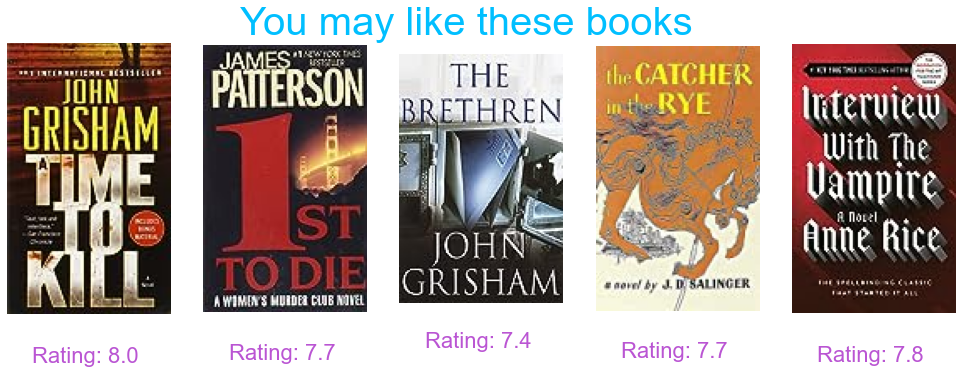

In [208]:
rec = ItemBasedRecommender()
rec.recommend('Wild Animus')

In [210]:
rec.recommend('From One to One Hundred')

No Recommendations for this Book
You may like these books
1st to Die A Novel
The Five People You Meet in Heaven
Good in Bed


In [211]:
rec.recommend('HAHAHAHA')

Could not find the book


---
## User-based collaborative filtering
Here, we look for the users who have rated various items in the same way

In [214]:
from sklearn.metrics.pairwise import cosine_similarity

In [212]:
new_df = df[df['id'].map(df['id'].value_counts()) > 200]
users_pivot = new_df.pivot_table(index=['id'], columns=['title'], values='rating')
users_pivot.fillna(0, inplace=True)

In [240]:
class UserBasedRecommender:
    def users_choice(self, id):
        users_fav = new_df[new_df['id'] == id].sort_values(['rating'], ascending=False)[0:5]
        return users_fav
    
    def user_based(self, new_df, id):
        if id not in new_df['id'].values:
            print('User not found')
        else:
            index = np.where(users_pivot.index == id)[0][0]
            similarity = cosine_similarity(users_pivot)
            similar_users = list(enumerate(similarity[index]))
            similar_users = sorted(similar_users, key=lambda x:x[1], reverse=True)[0:5]
            user_rec=[]
            for i in similar_users:
                    data =df[df['id'] == users_pivot.index[i[0]]]
                    user_rec.extend(list(data.drop_duplicates('id')['id'].values))
        return user_rec
    
    def common(self, new_df, user, user_id):
        x = new_df[new_df['id'] == user_id]
        recommend_books = []
        user = list(user)
        for i in user:
            y = new_df[(new_df['id'] == i)]
            books = y.loc[~y['title'].isin(x['title']),:]
            books = books.sort_values(['rating'], ascending=False)[0:5]
            recommend_books.extend(books['title'].values)
        return recommend_books[0:5]
    
    def recommend(self, user_id):
        user_choice_df = pd.DataFrame(self.users_choice(user_id))
        user_favorite = self.users_choice(user_id)
        n = len(user_choice_df['title'].values)
        print('User: {} '.format(user_id))

        fig, ax = plt.subplots(1, n, figsize=(17, 5))
        fig.suptitle('The books you like', fontsize=40, color='salmon')
        for i in range(n):
                url = new_df.loc[new_df['title'] == user_choice_df['title'].tolist()[i], 'url'][:1].values[0]
                user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
                headers = {'User-Agent': user_agent,} 
                request = urllib.request.Request(url, None, headers)
                response = urllib.request.urlopen(request)
                data = response.read()
                img = Image.open(BytesIO(data))
                ax[i].imshow(img)
                ax[i].axis('off')
                ax[i].set_title('Rating: {} '.format(round(
                    new_df[new_df['title'] == user_choice_df['title'].tolist()[i]]['rating'].mean(), 1)),
                                y=-0.20, color='mediumorchid', fontsize=22)
                fig.show()

        user_based_rec = self.user_based(new_df, user_id)
        books_for_user = self.common(new_df, user_based_rec, user_id)
        books_for_userDF = pd.DataFrame(books_for_user, columns=['title'])

        fig, ax = plt.subplots(1 ,5, figsize=(17, 5))
        fig.suptitle('The books you may like', fontsize=40, color='mediumseagreen')
        for i in range(5):
            url = new_df.loc[new_df['title'] == books_for_userDF['title'].tolist()[i], 'url'][:1].values[0]
            user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
            headers = {'User-Agent': user_agent,} 
            request = urllib.request.Request(url, None, headers)
            response = urllib.request.urlopen(request)
            data = response.read()
            img = Image.open(BytesIO(data))
            ax[i].imshow(img)
            ax[i].axis('off')
            ax[i].set_title('Rating: {} '.format(round(
                new_df[new_df['title'] == books_for_userDF['title'].tolist()[i]]['rating'].mean(), 1)), 
                            y=-0.20, color='mediumorchid', fontsize=22)
            fig.show()

In [241]:
rec = UserBasedRecommender()

User: 11676 


C:\Users\ACER\AppData\Local\Temp\ipykernel_4676\1497319384.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\ACER\AppData\Local\Temp\ipykernel_4676\1497319384.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


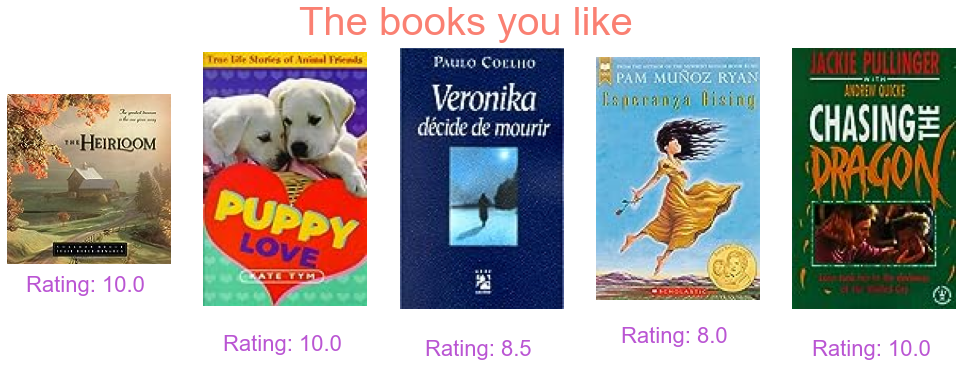

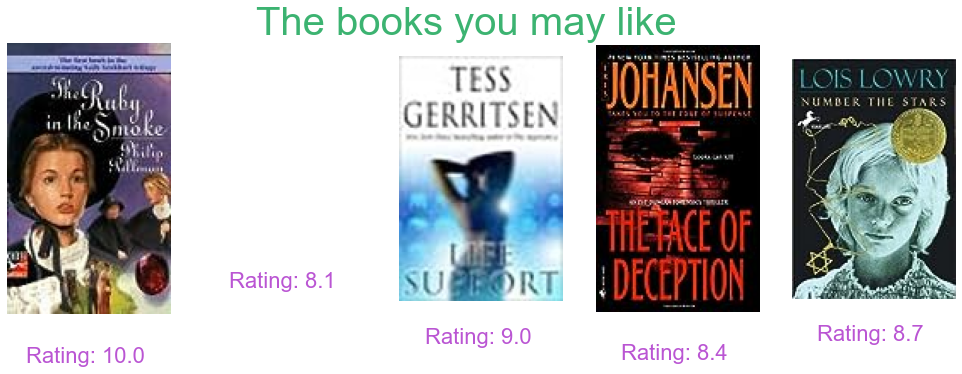

In [242]:
rec.recommend(11676)